In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from torchensemble.utils.logging import set_logger
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
import torchensemble
from enum import Enum 
from torchmetrics import Accuracy
import pandas as pd
import torch
%matplotlib inline

c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._reg

In [2]:
import time
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline  
from sklearn.svm import SVC
from sklearn import linear_model

In [3]:
df = pd.read_csv('dataset.csv', index_col=None);
df.tail()

,HH,Div,Date,HomeTeam,AwayTeam,FTR,HST,AST,HC,AC,...,league_id,season,stage,date,home_team_api_id,away_team_api_id,home_team_long_name,home_team_short_name,away_team_long_name,away_team_short_name
536,6067,E0,5/11/2016 0:00,Liverpool,Chelsea,D,9,7,7,3,...,1729,2015/2016,30,5/11/2016 0:00,8650,8455,Liverpool,LIV,Chelsea,CHE
537,6069,E0,5/11/2016 0:00,Sunderland,Everton,H,8,6,5,5,...,1729,2015/2016,30,5/11/2016 0:00,8472,8668,Sunderland,SUN,Everton,EVE
538,6070,E0,5/15/2016 0:00,Arsenal,Aston Villa,H,7,2,5,4,...,1729,2015/2016,38,5/15/2016 0:00,9825,10252,Arsenal,ARS,Aston Villa,AVL
539,6074,E0,5/15/2016 0:00,Southampton,Crystal Palace,H,5,4,2,5,...,1729,2015/2016,38,5/15/2016 0:00,8466,9826,Southampton,SOU,Crystal Palace,CRY
540,6077,E0,5/15/2016 0:00,Watford,Sunderland,D,6,4,7,4,...,1729,2015/2016,38,5/15/2016 0:00,9817,8472,Watford,WAT,Sunderland,SUN


In [4]:
df = df.drop(columns=['HH', 'Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTR', 'Result', 'match_api_id', \
                      'home_team_goals_difference', 'away_team_goals_difference', \
                        'League_1729.0', 'League_4769.0', \
                        'League_7809.0', 'League_10257.0', 'League_13274.0', 'League_19694.0', 'League_21518.0', \
                            'country_id', 'league_id', 'season', 'stage', 'date', \
                                'home_team_api_id', 'home_team_long_name', 'home_team_short_name', \
                                    'away_team_api_id', 'away_team_long_name', 'away_team_short_name'], axis=1)

df.tail()

,HST,AST,HC,AC,HAS,HDS,AAS,ADS,home_team_buildUpPlaySpeed,home_team_buildUpPlayPassing,...,away_player_3_overall_rating,away_player_4_overall_rating,away_player_5_overall_rating,away_player_6_overall_rating,away_player_7_overall_rating,away_player_8_overall_rating,away_player_9_overall_rating,away_player_10_overall_rating,away_player_11_overall_rating,outcome
536,9,7,7,3,1.233395,0.690260,1.389295,0.619937,66,45,...,82,77,77,86,83,83,88,83,74,Draw
537,8,6,5,5,0.587536,0.883299,0.956420,0.896425,43,51,...,77,75,82,80,79,80,80,77,82,Win
538,7,2,5,4,1.429960,0.739982,0.997368,1.082190,59,30,...,74,61,73,76,74,75,72,76,75,Win
539,5,4,2,5,0.568096,0.552793,0.236911,0.259207,52,46,...,71,74,75,76,76,75,71,71,78,Win
540,6,4,7,4,0.084242,0.128693,0.640538,0.915866,61,52,...,74,75,59,75,60,79,67,74,76,Draw


In [5]:
df = df.drop(['home_team_buildUpPlaySpeed', 'home_team_buildUpPlayPassing',
       'home_team_chanceCreationPassing', 'home_team_chanceCreationCrossing',
       'home_team_chanceCreationShooting', 'home_team_defencePressure',
       'home_team_defenceAggression', 'home_team_defenceTeamWidth',
       'home_team_avg_shots', 'home_team_avg_corners', 'home_team_avg_crosses',
       'away_team_buildUpPlaySpeed', 'away_team_buildUpPlayPassing',
       'away_team_chanceCreationPassing', 'away_team_chanceCreationCrossing',
       'away_team_chanceCreationShooting', 'away_team_defencePressure',
       'away_team_defenceAggression', 'away_team_defenceTeamWidth',
       'away_team_avg_shots', 'away_team_avg_corners', 'away_team_avg_crosses',
       'games_won_home_team', 'games_won_away_team', 'games_against_won',
       'games_against_lost'], axis=1)

df.tail()

,HST,AST,HC,AC,HAS,HDS,AAS,ADS,B365H,B365D,...,away_player_3_overall_rating,away_player_4_overall_rating,away_player_5_overall_rating,away_player_6_overall_rating,away_player_7_overall_rating,away_player_8_overall_rating,away_player_9_overall_rating,away_player_10_overall_rating,away_player_11_overall_rating,outcome
536,9,7,7,3,1.233395,0.690260,1.389295,0.619937,2.00,3.80,...,82,77,77,86,83,83,88,83,74,Draw
537,8,6,5,5,0.587536,0.883299,0.956420,0.896425,1.75,4.00,...,77,75,82,80,79,80,80,77,82,Win
538,7,2,5,4,1.429960,0.739982,0.997368,1.082190,1.17,9.00,...,74,61,73,76,74,75,72,76,75,Win
539,5,4,2,5,0.568096,0.552793,0.236911,0.259207,1.36,5.50,...,71,74,75,76,76,75,71,71,78,Win
540,6,4,7,4,0.084242,0.128693,0.640538,0.915866,2.05,3.75,...,74,75,59,75,60,79,67,74,76,Draw


In [6]:
df = df.dropna()

In [7]:
df.columns

Index(['HST', 'AST', 'HC', 'AC', 'HAS', 'HDS', 'AAS', 'ADS', 'B365H', 'B365D',
       'B365A', 'home_player_1_overall_rating', 'home_player_2_overall_rating',
       'home_player_3_overall_rating', 'home_player_4_overall_rating',
       'home_player_5_overall_rating', 'home_player_6_overall_rating',
       'home_player_7_overall_rating', 'home_player_8_overall_rating',
       'home_player_9_overall_rating', 'home_player_10_overall_rating',
       'home_player_11_overall_rating', 'away_player_1_overall_rating',
       'away_player_2_overall_rating', 'away_player_3_overall_rating',
       'away_player_4_overall_rating', 'away_player_5_overall_rating',
       'away_player_6_overall_rating', 'away_player_7_overall_rating',
       'away_player_8_overall_rating', 'away_player_9_overall_rating',
       'away_player_10_overall_rating', 'away_player_11_overall_rating',
       'outcome'],
      dtype='object')

In [8]:
df_temp = df[['home_player_1_overall_rating', 'home_player_2_overall_rating',
       'home_player_3_overall_rating', 'home_player_4_overall_rating',
       'home_player_5_overall_rating', 'home_player_6_overall_rating',
       'home_player_7_overall_rating', 'home_player_8_overall_rating',
       'home_player_9_overall_rating', 'home_player_10_overall_rating',
       'home_player_11_overall_rating', 'away_player_1_overall_rating',
       'away_player_2_overall_rating', 'away_player_3_overall_rating',
       'away_player_4_overall_rating', 'away_player_5_overall_rating',
       'away_player_6_overall_rating', 'away_player_7_overall_rating',
       'away_player_8_overall_rating', 'away_player_9_overall_rating',
       'away_player_10_overall_rating', 'away_player_11_overall_rating']]
df_temp.tail()

,home_player_1_overall_rating,home_player_2_overall_rating,home_player_3_overall_rating,home_player_4_overall_rating,home_player_5_overall_rating,home_player_6_overall_rating,home_player_7_overall_rating,home_player_8_overall_rating,home_player_9_overall_rating,home_player_10_overall_rating,...,away_player_2_overall_rating,away_player_3_overall_rating,away_player_4_overall_rating,away_player_5_overall_rating,away_player_6_overall_rating,away_player_7_overall_rating,away_player_8_overall_rating,away_player_9_overall_rating,away_player_10_overall_rating,away_player_11_overall_rating
536,78,80,79,78,77,80,75,80,82,84,...,82,82,77,77,86,83,83,88,83,74
537,74,71,74,76,74,75,75,77,78,78,...,63,77,75,82,80,79,80,80,77,82
538,86,77,84,78,80,79,81,86,88,85,...,58,74,61,73,76,74,75,72,76,75
539,76,69,77,81,78,73,77,78,76,78,...,76,71,74,75,76,76,75,71,71,78
540,76,72,76,74,72,72,70,71,75,77,...,71,74,75,59,75,60,79,67,74,76


In [9]:
df = df.drop(['home_player_1_overall_rating', 'home_player_2_overall_rating',
       'home_player_3_overall_rating', 'home_player_4_overall_rating',
       'home_player_5_overall_rating', 'home_player_6_overall_rating',
       'home_player_7_overall_rating', 'home_player_8_overall_rating',
       'home_player_9_overall_rating', 'home_player_10_overall_rating',
       'home_player_11_overall_rating', 'away_player_1_overall_rating',
       'away_player_2_overall_rating', 'away_player_3_overall_rating',
       'away_player_4_overall_rating', 'away_player_5_overall_rating',
       'away_player_6_overall_rating', 'away_player_7_overall_rating',
       'away_player_8_overall_rating', 'away_player_9_overall_rating',
       'away_player_10_overall_rating', 'away_player_11_overall_rating'], axis=1)

In [10]:
df_temp = pd.DataFrame(df_temp)
pca = PCA(n_components=10)
pca.fit(df_temp)
pca.explained_variance_ratio_.sum()

0.7816593758294258

In [11]:
df_temp = pca.transform(df_temp)
df_temp = pd.DataFrame(df_temp)

In [12]:
outcomes = df['outcome']

def encode(data):
    # encode the class label
    le = preprocessing.LabelEncoder()
    if(data=='Win'):
        return 2;
    if(data=='Draw'):
        return 1;
    if(data=='Defeat'):
        return 0;

outcomes = outcomes.apply(encode)
outcomes = pd.DataFrame(outcomes)
outcomes.tail()

,outcome
536,1
537,2
538,2
539,2
540,1


In [13]:
df = df.drop(columns=['outcome'], axis=1)
df.tail()

,HST,AST,HC,AC,HAS,HDS,AAS,ADS,B365H,B365D,B365A
536,9,7,7,3,1.233395,0.690260,1.389295,0.619937,2.00,3.80,3.8
537,8,6,5,5,0.587536,0.883299,0.956420,0.896425,1.75,4.00,5.0
538,7,2,5,4,1.429960,0.739982,0.997368,1.082190,1.17,9.00,17.0
539,5,4,2,5,0.568096,0.552793,0.236911,0.259207,1.36,5.50,9.0
540,6,4,7,4,0.084242,0.128693,0.640538,0.915866,2.05,3.75,3.7


In [14]:
df_temp.tail()

,0,1,2,3,4,5,6,7,8,9
536,-1.536202,-18.046928,2.079882,-1.449557,4.533621,1.613389,1.551730,0.796618,1.686251,-3.216649
537,-4.273281,1.416371,2.650995,5.342347,-9.928085,3.055038,2.379932,-1.687633,-5.527952,-2.692120
538,25.160587,3.628761,5.257006,8.091025,-2.874321,0.903967,-1.674997,-3.331742,-4.389955,1.534296
539,3.191486,8.057030,-9.595790,-1.228450,-2.760842,2.197465,-4.515607,1.653777,-0.700779,0.527612
540,2.848854,21.863728,3.613288,-5.136899,1.535456,-3.508839,6.562930,2.960677,9.986415,6.961477


In [15]:
df = pd.concat([df, df_temp], axis = 1)
df.tail()

,HST,AST,HC,AC,HAS,HDS,AAS,ADS,B365H,B365D,...,0,1,2,3,4,5,6,7,8,9
536,9,7,7,3,1.233395,0.690260,1.389295,0.619937,2.00,3.80,...,-1.536202,-18.046928,2.079882,-1.449557,4.533621,1.613389,1.551730,0.796618,1.686251,-3.216649
537,8,6,5,5,0.587536,0.883299,0.956420,0.896425,1.75,4.00,...,-4.273281,1.416371,2.650995,5.342347,-9.928085,3.055038,2.379932,-1.687633,-5.527952,-2.692120
538,7,2,5,4,1.429960,0.739982,0.997368,1.082190,1.17,9.00,...,25.160587,3.628761,5.257006,8.091025,-2.874321,0.903967,-1.674997,-3.331742,-4.389955,1.534296
539,5,4,2,5,0.568096,0.552793,0.236911,0.259207,1.36,5.50,...,3.191486,8.057030,-9.595790,-1.228450,-2.760842,2.197465,-4.515607,1.653777,-0.700779,0.527612
540,6,4,7,4,0.084242,0.128693,0.640538,0.915866,2.05,3.75,...,2.848854,21.863728,3.613288,-5.136899,1.535456,-3.508839,6.562930,2.960677,9.986415,6.961477


In [16]:
df.columns = df.columns.astype(str)
df.tail()

,HST,AST,HC,AC,HAS,HDS,AAS,ADS,B365H,B365D,...,0,1,2,3,4,5,6,7,8,9
536,9,7,7,3,1.233395,0.690260,1.389295,0.619937,2.00,3.80,...,-1.536202,-18.046928,2.079882,-1.449557,4.533621,1.613389,1.551730,0.796618,1.686251,-3.216649
537,8,6,5,5,0.587536,0.883299,0.956420,0.896425,1.75,4.00,...,-4.273281,1.416371,2.650995,5.342347,-9.928085,3.055038,2.379932,-1.687633,-5.527952,-2.692120
538,7,2,5,4,1.429960,0.739982,0.997368,1.082190,1.17,9.00,...,25.160587,3.628761,5.257006,8.091025,-2.874321,0.903967,-1.674997,-3.331742,-4.389955,1.534296
539,5,4,2,5,0.568096,0.552793,0.236911,0.259207,1.36,5.50,...,3.191486,8.057030,-9.595790,-1.228450,-2.760842,2.197465,-4.515607,1.653777,-0.700779,0.527612
540,6,4,7,4,0.084242,0.128693,0.640538,0.915866,2.05,3.75,...,2.848854,21.863728,3.613288,-5.136899,1.535456,-3.508839,6.562930,2.960677,9.986415,6.961477


In [17]:
scaling = preprocessing.StandardScaler()
scaling.fit(df)
feature_data = scaling.transform(df)

In [191]:
# principal = PCA(n_components=20)
# principal.fit(df)
# principal.explained_variance_ratio_.sum()

In [192]:
# df = principal.transform(df)
# df = pd.DataFrame(df)

In [18]:
##########################
### SETTINGS
##########################

RANDOM_SEED = 1
BATCH_SIZE = 16
NUM_EPOCHS = 100
NUM_FEATURES= df.shape[1]
learning_rate = 0.001
weight_decay = 0.001
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [19]:
train_data, test_data, train_targets, test_targets = train_test_split(df, outcomes, test_size=0.2, random_state=123)

In [20]:
print(f"X Train Set: {train_data.shape}")
print(f"X Test Set: {test_data.shape}")
print(f"y Train Set: {train_targets.shape}")
print(f"y Test Set: {test_targets.shape}")

X Train Set: (432, 21)
X Test Set: (109, 21)
y Train Set: (432, 1)
y Test Set: (109, 1)


In [28]:
class CustomDataset(Dataset):
    def __init__(self, data, targets):
        self.data = np.array(data)
        self.targets = np.array(targets)
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_tensor = torch.tensor(self.data[idx], dtype=torch.float32)
        target_tensor = torch.tensor(self.targets[idx], dtype=torch.long).squeeze()
        return data_tensor, target_tensor

In [29]:
train_dataset = CustomDataset(train_data, train_targets)
test_dataset = CustomDataset(test_data, test_targets)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, drop_last=True, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, drop_last=True, shuffle=True)

In [30]:
train_dataset[0]

(tensor([10.0000,  1.0000, 13.0000,  3.0000,  1.4040,  0.6932,  0.6464,  0.8597,
          1.3000,  5.7500, 12.0000, 16.7362, -7.2678, -4.3147,  0.5221,  0.4566,
          1.1773,  4.2474,  0.2326,  2.1076,  0.7199]),
 tensor(2))

In [31]:
class MLP(torch.nn.Module):

    def __init__(self):
        super().__init__()

        self.num_classes = 3
        self.num_features = NUM_FEATURES

        self.my_network = torch.nn.Sequential(
            # 1st hidden layer
            torch.nn.Flatten(),
            torch.nn.Linear(self.num_features, 256),
            torch.nn.BatchNorm1d(256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),

            # 2nd hidden layer
            torch.nn.Linear(256, 500),
            torch.nn.BatchNorm1d(500),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),

            # 3rd hidden layer
            torch.nn.Linear(500, 100),
            torch.nn.BatchNorm1d(100),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.4),

            # 4th hidden layer
            torch.nn.Linear(100, 50),
            torch.nn.BatchNorm1d(50),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            # 5th hidden layer
            torch.nn.Linear(50, 20),
            torch.nn.BatchNorm1d(20),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),


            # output hidden layer
            torch.nn.Linear(20, self.num_classes),
        )
        
        for m in self.modules():
            if isinstance(m, torch.nn.Linear):
                torch.nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    m.bias.detach().zero_()


    def forward(self, x):
        logits = self.my_network(x)
        probas = torch.softmax(logits, dim=1)
        # prediction = torch.argmax(logits, dim=1)
        return probas.unsqueeze(dim=1)

In [32]:
def compute_accuracy(model, X_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in X_loader:
            inputs = inputs.view(-1, NUM_FEATURES).to(DEVICE)
            targets = targets.view(-1,1).to(DEVICE)
            logits = model.forward(inputs)
            predicted = torch.argmax(logits, dim=1)
            total += targets.size(0)
            correct += (predicted == targets.view(-1)).sum().item()
        accuracy = correct / total * 100
        return accuracy


def compute_loss(model, X_loader):
    model.eval()
    with torch.no_grad():
        epoch_loss = 0
        for inputs, targets in X_loader:
            inputs = inputs.view(-1, NUM_FEATURES).to(DEVICE)
            targets = targets.view(-1,1).to(DEVICE)
            logits = model.forward(inputs)
            loss = F.cross_entropy(logits, targets.view(-1))
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(X_loader)
        return avg_loss

In [201]:
# logger = set_logger('BaggingClassifier')

# model = torchensemble.bagging.BaggingClassifier(estimator=MLP, n_estimators=10,cuda=False)

# criterion = nn.CrossEntropyLoss()
# model.set_criterion(criterion)

# model.set_optimizer('Adam', lr=1e-3, weight_decay=5e-4)
# model.set_scheduler('StepLR', step_size=3)

# model.fit(
#     train_loader,
#     epochs=10,
#     test_loader=test_loader,
# )

In [34]:
logger = set_logger('BaggingClassifier')

model = torchensemble.bagging.BaggingClassifier(estimator=MLP, n_estimators=10,cuda=False)

criterion = nn.CrossEntropyLoss()
model.set_criterion(criterion)

model.set_optimizer('Adam', lr=1e-3, weight_decay=5e-4)

model.fit(
    train_loader,
    epochs=50,
    test_loader=test_loader,
)

Log will be saved in 'c:\Users\hp\Downloads\Data for WARP\logs'.
Start logging into file c:\Users\hp\Downloads\Data for WARP\logs\BaggingClassifier-2024_05_30_14_27.log...


RuntimeError: Expected target size [16, 3], got [16]

In [ ]:
## Model initialization

torch.manual_seed(RANDOM_SEED)
model = MLP()

model = model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       mode='max',
                                                       verbose=True)


train_acc_data = []
train_cost_data = []
test_acc_data = []
test_cost_data = []

In [ ]:
model.train()
for epoch in range(NUM_EPOCHS):
    model.train()

    for inputs, targets in train_loader:
    
        inputs = torch.tensor(inputs)
        inputs = inputs.view(-1, NUM_FEATURES).to(DEVICE)
        targets = targets.view(-1).to(DEVICE)

        logits = model.forward(inputs.view(-1, NUM_FEATURES))

        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
    
    model.eval()

    with torch.no_grad():
        
        train_loss = compute_loss(model, train_loader)
        test_loss = compute_loss(model, test_loader)
        train_acc = compute_accuracy(model, train_loader)
        test_acc = compute_accuracy(model, test_loader)

        train_acc_data.append(train_acc)
        test_acc_data.append(test_acc)
        train_cost_data.append(train_loss)
        test_cost_data.append(test_loss)

        scheduler.step(train_acc_data[-1])

        print(f"epoch: {epoch+1}/{NUM_EPOCHS}", end="")
        print(" | train_loss: %.4f" %train_loss, end = "")
        print(" | train_accuracy: %.2f" %train_acc, end = "")
        print(" || test_loss: %.4f" %test_loss, end = "")
        print(" | tset_accuracy: %.2f" %test_acc)

C:\Users\hp\AppData\Local\Temp\ipykernel_21072\3132252864.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs)


epoch: 1/100 | train_loss: 2.8453 | train_accuracy: 10.42 || test_loss: 2.8528 | tset_accuracy: 10.42
epoch: 2/100 | train_loss: 2.4555 | train_accuracy: 38.66 || test_loss: 2.5122 | tset_accuracy: 40.62
epoch: 3/100 | train_loss: 2.1841 | train_accuracy: 47.22 || test_loss: 2.2421 | tset_accuracy: 50.00
epoch: 4/100 | train_loss: 1.9015 | train_accuracy: 50.93 || test_loss: 1.9524 | tset_accuracy: 50.00
epoch: 5/100 | train_loss: 1.7099 | train_accuracy: 52.78 || test_loss: 1.8305 | tset_accuracy: 51.04
epoch: 6/100 | train_loss: 1.5219 | train_accuracy: 54.17 || test_loss: 1.5570 | tset_accuracy: 57.29
epoch: 7/100 | train_loss: 1.3962 | train_accuracy: 54.40 || test_loss: 1.4376 | tset_accuracy: 56.25
epoch: 8/100 | train_loss: 1.2549 | train_accuracy: 56.25 || test_loss: 1.3276 | tset_accuracy: 55.21
epoch: 9/100 | train_loss: 1.1703 | train_accuracy: 58.10 || test_loss: 1.2778 | tset_accuracy: 53.12
epoch: 10/100 | train_loss: 1.1161 | train_accuracy: 59.72 || test_loss: 1.1763 | 

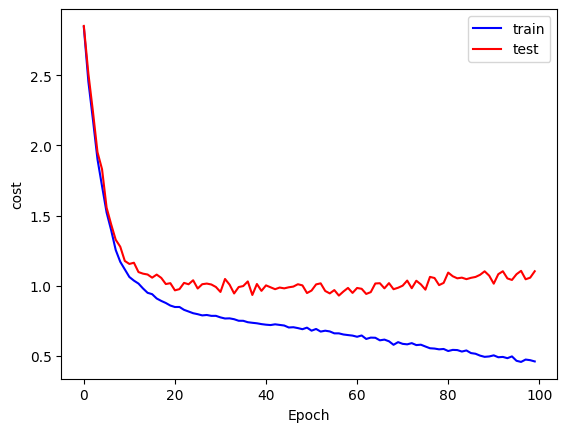

In [ ]:
plt.plot(range(len(train_cost_data)), train_cost_data, color = 'blue')
plt.plot(range(len(test_cost_data)), test_cost_data, color = 'red')
plt.xlabel('Epoch')
plt.ylabel('cost')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

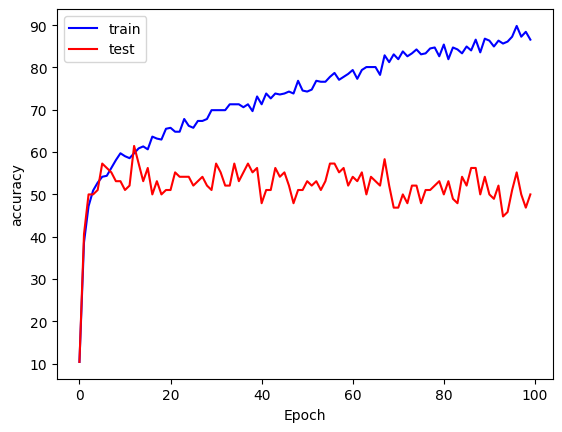

In [ ]:
plt.plot(range(len(train_acc_data)), train_acc_data, color = 'blue')
plt.plot(range(len(test_acc_data)), test_acc_data, color = 'red')
plt.legend(['train', 'test'], loc='upper left')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.show()

In [ ]:
# Access the weights of the model
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

my_network.1.weight tensor([[ 0.5076, -0.5901,  0.2843,  ..., -0.1907, -0.3901, -0.3999],
        [ 0.0890,  0.5172, -0.1965,  ..., -0.4658,  0.2894,  0.0036],
        [ 0.3389,  0.3078,  0.0270,  ..., -0.3899, -0.2789,  0.0310],
        ...,
        [ 0.2020, -0.2153, -0.2074,  ...,  0.4475, -0.4474,  0.1184],
        [-0.0951, -0.0031,  0.1041,  ..., -0.1745,  0.3957,  0.1520],
        [-0.1400, -0.2422, -0.1330,  ..., -0.0969, -0.1333,  0.4141]])
my_network.1.bias tensor([-3.5834e-05, -2.7864e-06, -1.0891e-05,  1.3599e-05, -1.6383e-06,
        -3.5730e-05, -1.7359e-05,  2.1998e-06,  1.8978e-06,  6.0732e-06,
        -7.3911e-06,  2.0087e-05,  3.6690e-06,  6.3895e-07, -9.1991e-06,
         1.1151e-05, -1.7297e-05,  1.6503e-05, -4.9539e-06, -4.3420e-06,
         1.8355e-05, -1.2764e-06,  1.1749e-06,  8.2731e-06, -4.6626e-05,
        -5.6163e-06, -6.2116e-06,  4.4494e-05, -3.4378e-05, -4.3989e-06,
        -1.0860e-05, -1.0819e-05, -4.5639e-06,  2.9557e-05, -1.0338e-05,
         3.0501e-

In [ ]:
threshold = model.my_network[-1].bias
print("Threshold at the last layer:", threshold)

Threshold at the last layer: Parameter containing:
tensor([ 0.2638,  0.2286,  0.3105, -0.3477, -0.3419, -0.3456, -0.3210, -0.3107,
        -0.3340, -0.3186, -0.3313, -0.3308, -0.3219, -0.3108, -0.3375, -0.3253,
        -0.3081, -0.3174, -0.3224, -0.3386, -0.3270], requires_grad=True)


In [ ]:
# model.eval()
# with torch.no_grad():
#     logits, _ = model(X_test)
#     predictions = torch.argmax(logits, dim=1).numpy()

# # Compute confusion matrix
# conf_matrix = confusion_matrix(y_test, predictions)

# # Print confusion matrix
# print("Confusion Matrix:")
# print(conf_matrix)